# Problem

Banks run into losses when a customer doesn't pay their loans on time. Because of this, every year, banks have losses in crores, and this also impacts the country's economic growth to a large extent. In this ML hackathon, we have been asked to predict if a person will be a loan defaulter or not.

## Evaluation

The submission will be evaluated using the logloss metric.

## Competition Home Page

https://machinehack.com/hackathons/deloitte_presents_machine_learning_challenge_predict_loan_defaulters/overview

## Leaderboard

Public(30% data): 0.35350 (Rank 1/1273)

Private(100% data): 0.34099 (Rank 1/1273)

# (1) Load Data from Google drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!cp '/gdrive/My Drive/Deep_learning_app/Machinehack_deloitte_loan_default_prediction/data/train.csv' .
!cp '/gdrive/My Drive/Deep_learning_app/Machinehack_deloitte_loan_default_prediction/data/test.csv' .
!cp '/gdrive/My Drive/Deep_learning_app/Machinehack_deloitte_loan_default_prediction/data/submission.csv' .

In [ ]:
!ls

sample_data  submission.csv  test.csv  train.csv


# (2) Install Packages

In [ ]:
!pip install shap

     |████████████████████████████████| 564 kB 5.3 MB/s 


In [ ]:
!pip install feature-engine

     |████████████████████████████████| 180 kB 3.3 MB/s 
     |████████████████████████████████| 9.8 MB 41.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
!pip freeze > requirements.txt
!cat requirements.txt

absl-py==0.12.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
appdirs==1.4.4
argcomplete==1.12.3
argon2-cffi==21.1.0
arviz==0.11.4
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.2.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==4.1.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.10
cached-property==1.5.2
cachetools==4.2.4
catalogue==1.0.0
certifi==2021.10.8
cffi==1.15.0
cftime==1.5.1.1
chardet==3.0.4
charset-normalizer==2.0.8
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==2.0.6
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.3.2
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.24
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.4
distributed==1.25.3


# (3) Import Packages

In [ ]:
## Package used for Data Analysis
import pandas as pd
import numpy as np

## Package used for Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Package used for model building
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
import xgboost as xgb

## Package used for Categorical encoding
from feature_engine.encoding import CountFrequencyEncoder

## Model Interpretation package
import shap
shap.initjs()

import warnings
warnings.filterwarnings("ignore")

## Package version
print(f'Pandas Version: {pd.__version__}')
print(f'numpy Version: {np.__version__}')
print(f'sklearn Version: {sklearn.__version__}')
print(f'xgboost Version: {xgb.__version__}')
print(f'shap Version: {shap.__version__}')
print(f'seaborn Version: {sns.__version__}')

Pandas Version: 1.1.5
numpy Version: 1.19.5
sklearn Version: 1.0.1
xgboost Version: 0.90
shap Version: 0.40.0
seaborn Version: 0.11.2


# (4) Load data

In [ ]:
## Files
train_file      = 'train.csv'
test_file       = 'test.csv'
sub_file        = 'submission.csv'

In [ ]:
# Load train dataset 
try:
    train = pd.read_csv(train_file, low_memory = False)
    print("The train dataset has {} samples with {} features.".format(*train.shape))
except:
    print("The train dataset could not be loaded. Is the dataset missing?")

# Load test dataset 
try:
    test = pd.read_csv(test_file, low_memory = False)
    print("The test dataset has {} samples with {} features.".format(*test.shape))
except:
    print("The test dataset could not be loaded. Is the dataset missing?")

The train dataset has 67463 samples with 35 features.
The test dataset has 28913 samples with 35 features.


# (5) Introduction To The Data

In [ ]:
train.head()

,ID,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,Home Ownership,Verification Status,Payment Plan,Loan Title,Debit to Income,Delinquency - two years,Inquires - six months,Open Account,Public Record,Revolving Balance,Revolving Utilities,Total Accounts,Initial List Status,Total Received Interest,Total Received Late Fee,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
0,65087372,10000,32236,12329.36286,59,BAT2522922,11.135007,B,C4,MORTGAGE,176346.62670,Not Verified,n,Debt Consolidation,16.284758,1,0,13,0,24246,74.932551,7,w,2929.646315,0.102055,2.498291,0.793724,0,INDIVIDUAL,49,0,31,311301,6619,0
1,1450153,3609,11940,12191.99692,59,BAT1586599,12.237563,C,D3,RENT,39833.92100,Source Verified,n,Debt consolidation,15.412409,0,0,12,0,812,78.297186,13,f,772.769385,0.036181,2.377215,0.974821,0,INDIVIDUAL,109,0,53,182610,20885,0
2,1969101,28276,9311,21603.22455,59,BAT2136391,12.545884,F,D4,MORTGAGE,91506.69105,Source Verified,n,Debt Consolidation,28.137619,0,0,14,0,1843,2.073040,20,w,863.324396,18.778660,4.316277,1.020075,0,INDIVIDUAL,66,0,34,89801,26155,0
3,6651430,11170,6954,17877.15585,59,BAT2428731,16.731201,C,C3,MORTGAGE,108286.57590,Source Verified,n,Debt consolidation,18.043730,1,0,7,0,13819,67.467951,12,w,288.173196,0.044131,0.107020,0.749971,0,INDIVIDUAL,39,0,40,9189,60214,0
4,14354669,16890,13226,13539.92667,59,BAT5341619,15.008300,C,D4,MORTGAGE,44234.82545,Source Verified,n,Credit card refinancing,17.209886,1,3,13,1,1544,85.250761,22,w,129.239553,19.306646,1294.818751,0.368953,0,INDIVIDUAL,18,0,430,126029,22579,0


In [ ]:
test.head()

,ID,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,Home Ownership,Verification Status,Payment Plan,Loan Title,Debit to Income,Delinquency - two years,Inquires - six months,Open Account,Public Record,Revolving Balance,Revolving Utilities,Total Accounts,Initial List Status,Total Received Interest,Total Received Late Fee,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
0,56492997,17120,10365,16025.082690,59,BAT2575549,12.163926,A,D1,RENT,76468.82190,Source Verified,n,Home improvement,16.749219,1,0,12,1,3576,67.278287,5,f,4469.449851,0.088031,8.425776,0.731797,0,INDIVIDUAL,135,0,24,475442,4364,NaN
1,22540813,7133,11650,12615.795600,59,BAT2833642,6.564296,B,E3,MORTGAGE,38079.01344,Source Verified,n,Credit card refinancing,18.157975,0,0,11,0,1932,71.313157,21,w,993.907530,0.041237,6.157008,0.992918,0,INDIVIDUAL,56,0,1,72412,2573,NaN
2,9862181,25291,25825,11621.280830,59,BAT1761981,14.729900,A,C3,MORTGAGE,51275.93268,Source Verified,n,Debt consolidation,15.190011,0,0,22,0,598,50.883065,23,f,729.113379,0.021745,5.705077,0.281580,0,INDIVIDUAL,3,0,26,284825,19676,NaN
3,10097822,30781,9664,15375.823510,59,BAT5341619,10.523767,A,A2,RENT,68867.98965,Verified,n,Debt Consolidation,21.292550,0,0,11,0,5222,82.449083,28,w,715.867091,0.092398,2.469688,0.959162,0,INDIVIDUAL,21,0,32,40842,7226,NaN
4,47771809,8878,9419,7176.647582,58,BAT4694572,9.997013,C,B3,OWN,91556.85423,Verified,n,Debt consolidation,4.812117,0,0,11,0,553,49.075855,9,w,248.572854,0.010354,2.127835,0.402315,0,INDIVIDUAL,104,0,33,90825,26145,NaN


In [ ]:
train['Loan Status'].value_counts() / train.shape[0]

0    0.90749
1    0.09251
Name: Loan Status, dtype: float64

Text(0, 0.5, 'Count')

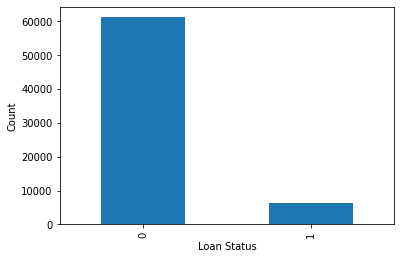

In [ ]:
train['Loan Status'].value_counts().plot(kind='bar')
plt.xlabel('Loan Status')
plt.ylabel('Count')

In [ ]:
train.describe()

,ID,Loan Amount,Funded Amount,Funded Amount Investor,Term,Interest Rate,Home Ownership,Debit to Income,Delinquency - two years,Inquires - six months,Open Account,Public Record,Revolving Balance,Revolving Utilities,Total Accounts,Total Received Interest,Total Received Late Fee,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
count,6.746300e+04,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.0,67463.000000,6.746300e+04,67463.000000,67463.000000
mean,2.562761e+07,16848.902776,15770.599114,14621.799323,58.173814,11.846258,80541.502522,23.299241,0.327127,0.145754,14.266561,0.081437,7699.342425,52.889443,18.627929,2068.992542,1.143969,59.691578,1.125141,0.021301,71.163260,0.0,146.467990,1.595739e+05,23123.005544,0.092510
std,2.109155e+07,8367.865726,8150.992662,6785.345170,3.327441,3.718629,45029.120366,8.451824,0.800888,0.473291,6.225060,0.346606,7836.148190,22.539450,8.319246,2221.918745,5.244365,357.026346,3.489885,0.144385,43.315845,0.0,744.382233,1.390332e+05,20916.699999,0.289747
min,1.297933e+06,1014.000000,1014.000000,1114.590204,36.000000,5.320006,14573.537170,0.675299,0.000000,0.000000,2.000000,0.000000,0.000000,0.005172,4.000000,4.736746,0.000003,0.000036,0.000036,0.000000,0.000000,0.0,1.000000,6.170000e+02,1000.000000,0.000000
25%,6.570288e+06,10012.000000,9266.500000,9831.684984,58.000000,9.297147,51689.843335,16.756416,0.000000,0.000000,10.000000,0.000000,2557.000000,38.658825,13.000000,570.903814,0.021114,1.629818,0.476259,0.000000,35.000000,0.0,24.000000,5.037900e+04,8155.500000,0.000000
50%,1.791565e+07,16073.000000,13042.000000,12793.682170,59.000000,11.377696,69335.832680,22.656658,0.000000,0.000000,13.000000,0.000000,5516.000000,54.082334,18.000000,1330.842771,0.043398,3.344524,0.780141,0.000000,68.000000,0.0,36.000000,1.183690e+05,16733.000000,0.000000
75%,4.271521e+07,22106.000000,21793.000000,17807.594120,59.000000,14.193533,94623.322785,30.048400,0.000000,0.000000,16.000000,0.000000,10184.500000,69.177117,23.000000,2656.956837,0.071884,5.453727,1.070566,0.000000,105.000000,0.0,46.000000,2.283750e+05,32146.500000,0.000000
max,7.224578e+07,35000.000000,34999.000000,34999.746430,59.000000,27.182348,406561.536400,39.629862,8.000000,5.000000,37.000000,4.000000,116933.000000,100.880050,72.000000,14301.368310,42.618882,4354.467419,166.833000,1.000000,161.000000,0.0,16421.000000,1.177412e+06,201169.000000,1.000000


In [ ]:
test.describe()

,ID,Loan Amount,Funded Amount,Funded Amount Investor,Term,Interest Rate,Home Ownership,Debit to Income,Delinquency - two years,Inquires - six months,Open Account,Public Record,Revolving Balance,Revolving Utilities,Total Accounts,Total Received Interest,Total Received Late Fee,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
count,2.891300e+04,28913.000000,28913.000000,28913.000000,28913.000000,28913.000000,28913.000000,28913.000000,28913.000000,28913.000000,28913.000000,28913.000000,28913.000000,28913.000000,28913.000000,28913.000000,28913.000000,28913.000000,28913.000000,28913.000000,28913.000000,28913.000000,28913.000000,2.891300e+04,28913.000000,0.0
mean,2.944966e+07,16404.027462,15619.911113,14741.536698,54.543078,12.187577,79983.752348,22.159266,0.332065,0.276900,13.663439,0.111092,9937.451423,53.860078,20.398540,1917.754435,0.922863,50.624944,1.393220,0.019576,65.007574,0.000968,159.747553,1.530975e+05,25013.808425,NaN
std,2.206842e+07,8358.898287,8229.977503,7230.397758,8.991800,3.911259,45231.316383,8.657629,0.818869,0.663999,6.114777,0.388741,10931.313717,22.801701,9.650339,2109.442877,4.765042,336.450176,15.139809,0.138540,42.494090,0.031105,911.671785,1.391309e+05,22284.519460,NaN
min,1.297893e+06,1000.000000,1000.000000,1000.000000,36.000000,5.320000,14907.925920,0.730000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,4.000000,4.794657,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.260000e+02,1000.000000,NaN
25%,8.272049e+06,9776.000000,9175.000000,9695.445501,58.000000,9.422042,50791.000000,15.622891,0.000000,0.000000,10.000000,0.000000,3177.000000,38.997949,14.000000,524.130000,0.000000,0.000000,0.000000,0.000000,29.000000,0.000000,3.000000,4.397200e+04,9325.000000,NaN
50%,2.596622e+07,15600.000000,13200.000000,12930.601270,59.000000,11.688652,68894.324470,21.530000,0.000000,0.000000,12.000000,0.000000,6769.000000,54.867003,19.000000,1216.347147,0.027878,2.165909,0.579620,0.000000,60.000000,0.000000,30.000000,1.092860e+05,18848.000000,NaN
75%,4.855801e+07,21651.000000,21552.000000,19226.397540,59.000000,14.640000,94684.941810,28.840000,0.000000,0.000000,15.000000,0.000000,12803.000000,70.521791,25.000000,2474.594118,0.061107,4.610188,0.974739,0.000000,95.000000,0.000000,44.000000,2.222960e+05,33860.000000,NaN
max,7.226845e+07,35000.000000,35000.000000,35000.000000,60.000000,27.310000,406944.859000,39.629977,9.000000,5.000000,37.000000,4.000000,188657.000000,100.799622,73.000000,14313.816110,42.520996,4325.594909,743.166000,1.000000,161.000000,1.000000,27076.000000,1.183282e+06,233500.000000,NaN


In [ ]:
train.dtypes

ID                                int64
Loan Amount                       int64
Funded Amount                     int64
Funded Amount Investor          float64
Term                              int64
Batch Enrolled                   object
Interest Rate                   float64
Grade                            object
Sub Grade                        object
Employment Duration              object
Home Ownership                  float64
Verification Status              object
Payment Plan                     object
Loan Title                       object
Debit to Income                 float64
Delinquency - two years           int64
Inquires - six months             int64
Open Account                      int64
Public Record                     int64
Revolving Balance                 int64
Revolving Utilities             float64
Total Accounts                    int64
Initial List Status              object
Total Received Interest         float64
Total Received Late Fee         float64


In [ ]:
train.dtypes.value_counts()

int64      17
object      9
float64     9
dtype: int64

In [ ]:
train.isnull().sum() / train.shape[0]

ID                              0.0
Loan Amount                     0.0
Funded Amount                   0.0
Funded Amount Investor          0.0
Term                            0.0
Batch Enrolled                  0.0
Interest Rate                   0.0
Grade                           0.0
Sub Grade                       0.0
Employment Duration             0.0
Home Ownership                  0.0
Verification Status             0.0
Payment Plan                    0.0
Loan Title                      0.0
Debit to Income                 0.0
Delinquency - two years         0.0
Inquires - six months           0.0
Open Account                    0.0
Public Record                   0.0
Revolving Balance               0.0
Revolving Utilities             0.0
Total Accounts                  0.0
Initial List Status             0.0
Total Received Interest         0.0
Total Received Late Fee         0.0
Recoveries                      0.0
Collection Recovery Fee         0.0
Collection 12 months Medical

In [ ]:
train.isna().sum()

ID                              0
Loan Amount                     0
Funded Amount                   0
Funded Amount Investor          0
Term                            0
Batch Enrolled                  0
Interest Rate                   0
Grade                           0
Sub Grade                       0
Employment Duration             0
Home Ownership                  0
Verification Status             0
Payment Plan                    0
Loan Title                      0
Debit to Income                 0
Delinquency - two years         0
Inquires - six months           0
Open Account                    0
Public Record                   0
Revolving Balance               0
Revolving Utilities             0
Total Accounts                  0
Initial List Status             0
Total Received Interest         0
Total Received Late Fee         0
Recoveries                      0
Collection Recovery Fee         0
Collection 12 months Medical    0
Application Type                0
Last week Pay 

In [ ]:
test.isna().sum()

ID                                  0
Loan Amount                         0
Funded Amount                       0
Funded Amount Investor              0
Term                                0
Batch Enrolled                      0
Interest Rate                       0
Grade                               0
Sub Grade                           0
Employment Duration                 0
Home Ownership                      0
Verification Status                 0
Payment Plan                        0
Loan Title                          0
Debit to Income                     0
Delinquency - two years             0
Inquires - six months               0
Open Account                        0
Public Record                       0
Revolving Balance                   0
Revolving Utilities                 0
Total Accounts                      0
Initial List Status                 0
Total Received Interest             0
Total Received Late Fee             0
Recoveries                          0
Collection R

In [ ]:
{col:train[col].nunique() for col in train.columns}

{'Accounts Delinquent': 1,
 'Application Type': 2,
 'Batch Enrolled': 41,
 'Collection 12 months Medical': 2,
 'Collection Recovery Fee': 67313,
 'Debit to Income': 67454,
 'Delinquency - two years': 9,
 'Employment Duration': 3,
 'Funded Amount': 24548,
 'Funded Amount Investor': 67441,
 'Grade': 7,
 'Home Ownership': 67454,
 'ID': 67463,
 'Initial List Status': 2,
 'Inquires - six months': 6,
 'Interest Rate': 67448,
 'Last week Pay': 162,
 'Loan Amount': 27525,
 'Loan Status': 2,
 'Loan Title': 109,
 'Open Account': 36,
 'Payment Plan': 1,
 'Public Record': 5,
 'Recoveries': 67387,
 'Revolving Balance': 20582,
 'Revolving Utilities': 67458,
 'Sub Grade': 35,
 'Term': 3,
 'Total Accounts': 69,
 'Total Collection Amount': 2193,
 'Total Current Balance': 60901,
 'Total Received Interest': 67451,
 'Total Received Late Fee': 67380,
 'Total Revolving Credit Limit': 37708,
 'Verification Status': 3}

In [ ]:
{col:test[col].nunique() for col in test.columns}

{'Accounts Delinquent': 2,
 'Application Type': 2,
 'Batch Enrolled': 41,
 'Collection 12 months Medical': 2,
 'Collection Recovery Fee': 21603,
 'Debit to Income': 24447,
 'Delinquency - two years': 10,
 'Employment Duration': 3,
 'Funded Amount': 14552,
 'Funded Amount Investor': 22419,
 'Grade': 7,
 'Home Ownership': 22551,
 'ID': 28913,
 'Initial List Status': 2,
 'Inquires - six months': 6,
 'Interest Rate': 21675,
 'Last week Pay': 162,
 'Loan Amount': 15664,
 'Loan Status': 0,
 'Loan Title': 109,
 'Open Account': 36,
 'Payment Plan': 1,
 'Public Record': 5,
 'Recoveries': 21613,
 'Revolving Balance': 16204,
 'Revolving Utilities': 22494,
 'Sub Grade': 35,
 'Term': 4,
 'Total Accounts': 70,
 'Total Collection Amount': 1551,
 'Total Current Balance': 27569,
 'Total Received Interest': 28564,
 'Total Received Late Fee': 21535,
 'Total Revolving Credit Limit': 18308,
 'Verification Status': 3}

# (6) Feature Engineering

## Generate features for model training and evaluation

In [ ]:
# Excluded features & target field based on data analysis and featue importance
excluded_features = ['Loan Status', 'ID', 'Batch Enrolled', 'Payment Plan', 'Accounts Delinquent']
                    
# Define Target columns
target = train['Loan Status']

# Clean features values 
for df in [train, test]:
  df['Verification Status'] = df['Verification Status'].replace({'Source Verified': 'Verified'})

# Generate new features
for df in [train, test]:
  df['total_recovery'] = df['Recoveries'] + df['Collection Recovery Fee']  
  df['Collection_amt_plus_received_late_fee'] = df['Total Collection Amount'] + df['Total Received Late Fee']
  df['Interest Rate_category'] = pd.cut(df['Interest Rate'], 6)

# Define categorical features
categorical_columns = train.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_features = [col for col in categorical_columns if col not in excluded_features]

# Define numeric features
numeric_columns = train.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features = [col for col in numeric_columns if col not in excluded_features]

# Perform a log transformation for all numeric features
for df in [train, test]:
  for col in numeric_features:
     df[col] = np.log1p(df[col]) 

# Define final feature list for training and validation
features = numeric_features + categorical_features

# Final data for training and testing
train_cv = train[features]
test_cv = test[features]
train_cv.shape, test_cv.shape

((67463, 33), (28913, 33))

# (7) Xgboost Training

In [ ]:
# Define model training parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric' : 'logloss',
    'max_depth': 5,
    'eta': 0.005,
    'seed' : 1983,
    'verbose': 1,
    }

# Define Cross validation split
folds = KFold(n_splits=5, shuffle=True, random_state=15)

# Initialize some important dataframe for training/validation/prediction
xgb_oof_1 = np.zeros(len(train_cv))
xgb_predictions_1 = np.zeros(len(test_cv))
xgb_feature_importance_df = pd.DataFrame()
features = train_cv.columns

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_cv.values, target.values)):        
    X_train = train_cv.iloc[trn_idx]
    y_train = target.iloc[trn_idx]
    X_valid = train_cv.iloc[val_idx]
    y_valid = target.iloc[val_idx]

    # Set up the Count frequency encoder
    encoder = CountFrequencyEncoder(encoding_method='frequency',variables=categorical_features)

    # Fit the encoder
    encoder.fit(X_train[categorical_features], y_train)

    # Transform the data
    train_t= encoder.transform(X_train[categorical_features]).add_prefix('Count_')
    valid_t= encoder.transform(X_valid[categorical_features]).add_prefix('Count_')
    test_t= encoder.transform(test_cv[categorical_features]).add_prefix('Count_')

    # Concat original numerical train and new encoded categorical features
    X_train_final = pd.concat([X_train[numeric_features], train_t], axis=1)
    X_valid_final = pd.concat([X_valid[numeric_features], valid_t], axis=1)
    X_test_final = pd.concat([test_cv[numeric_features], test_t], axis=1)

    # Create data for XGboost training and evaluation    
    trn_data  = xgb.DMatrix(X_train_final, y_train)
    val_data  = xgb.DMatrix(X_valid_final, y_valid)
    d_test    = xgb.DMatrix(X_test_final)
    d_valid   = xgb.DMatrix(X_valid_final)   
    watchlist = [(trn_data, 'train'), (val_data, 'valid')]
    
    # Train Xgboost model
    num_round = 10000
    xgb_clf = xgb.train(params, 
                        trn_data, 
                        num_round, 
                        watchlist, 
                        early_stopping_rounds=70,
                        maximize=False, 
                        verbose_eval=100)    
    
    # Generate fold feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = list(xgb_clf.get_fscore().keys())
    fold_importance_df["importance"] = list(xgb_clf.get_fscore().values())
    fold_importance_df["fold"] = fold_ + 1
    xgb_feature_importance_df = pd.concat([xgb_feature_importance_df, fold_importance_df], axis=0)
    
    # Generate out of the fold predication
    xgb_oof_1[val_idx] = xgb_clf.predict(d_valid, ntree_limit=xgb_clf.best_ntree_limit) 
    # Generate test predication(Average)
    xgb_predictions_1 += xgb_clf.predict(d_test, ntree_limit=xgb_clf.best_ntree_limit) / folds.n_splits

[0]	train-logloss:0.689887	valid-logloss:0.689827
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 70 rounds.
[100]	train-logloss:0.474208	valid-logloss:0.474469
[200]	train-logloss:0.380547	valid-logloss:0.381298
[300]	train-logloss:0.337394	valid-logloss:0.339071
[400]	train-logloss:0.317164	valid-logloss:0.320116
[500]	train-logloss:0.307483	valid-logloss:0.311915
[600]	train-logloss:0.302564	valid-logloss:0.30856
[700]	train-logloss:0.299657	valid-logloss:0.307262
[800]	train-logloss:0.297588	valid-logloss:0.306757
[900]	train-logloss:0.295807	valid-logloss:0.306579
Stopping. Best iteration:
[929]	train-logloss:0.295358	valid-logloss:0.306561

[0]	train-logloss:0.689965	valid-logloss:0.689832
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 70 rounds.
[100]	train-logloss:0.47332	valid-logloss:0.476749
[

In [ ]:
print('LogLoss :{}'.format(log_loss(target ,xgb_oof_1)))

LogLoss :0.3082273434208472


### Feature Importance

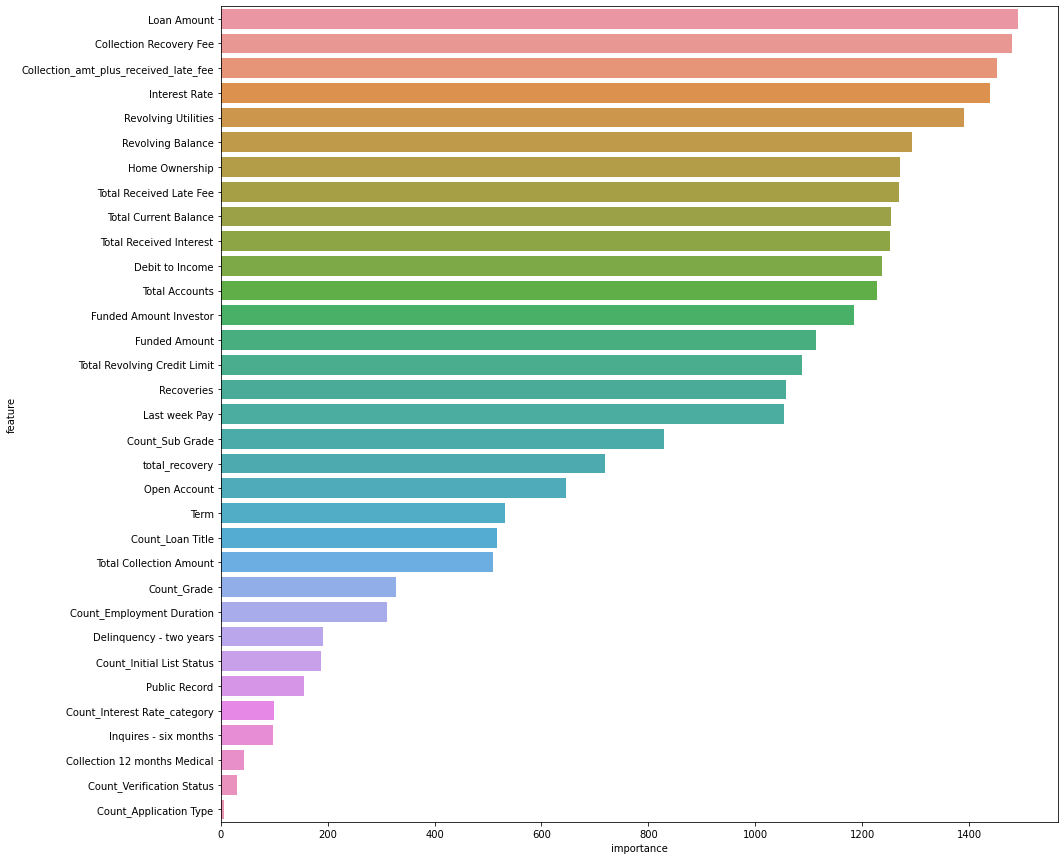

In [ ]:
feature_importance_df  = xgb_feature_importance_df.groupby('feature').mean().sort_values('importance', ascending=False).reset_index()
plt.figure(figsize = (15, 15))
sns.barplot(x ='importance', y ='feature', data= feature_importance_df[:50])

# (8) Model Output Interpretation

## SHAP : GLOBAL EXPLANATIONS
The SHAP library also provides with easy ways to aggregate and plot the Shapely values for a set of points(in our case the train/validation set) to have a global explanation for the model.

### SHAP Summary Plot : Feature Impact 
Rather than use a typical feature importance bar chart, we use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. 

Note that when the scatter points don't fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.

In [ ]:
# Initialize SHAP Tree explainer
explainer = shap.TreeExplainer(xgb_clf, model_output='margin')
shap_values = explainer.shap_values(X_valid_final)

# Baseline value
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

Explainer expected value: -2.2522246837615967


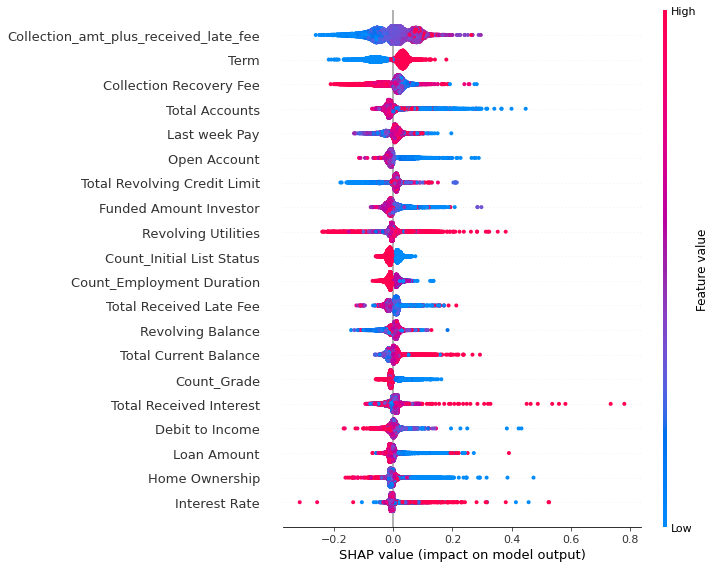

In [ ]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_valid_final)

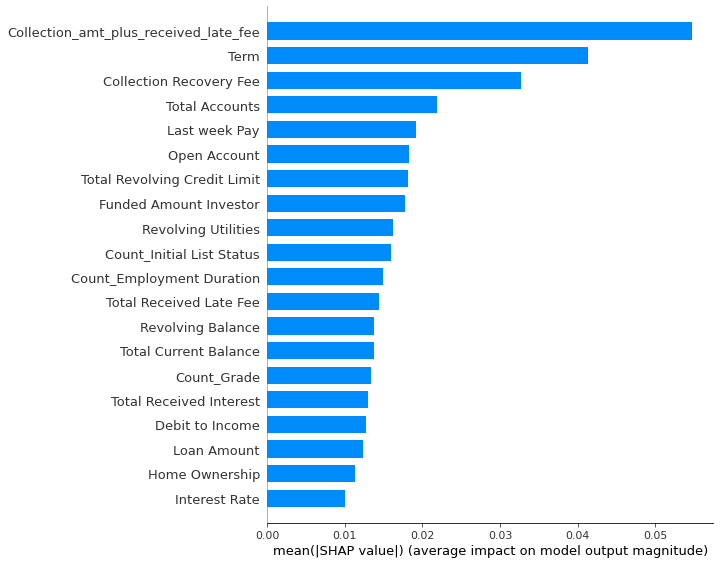

In [ ]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_valid_final, plot_type='bar')

# (9) Submission

In [ ]:
sub = pd.read_csv(sub_file)
sub.head()

,Loan Status
0,0
1,0
2,0
3,0
4,0


In [ ]:
sub_df = pd.DataFrame()
sub_df['Loan Status'] = xgb_predictions_1
sub_df.to_csv('MH_loan_default_prediction_1212_v03.csv', index=False)
sub_df.head()

,Loan Status
0,0.104063
1,0.078084
2,0.093068
3,0.094329
4,0.085361


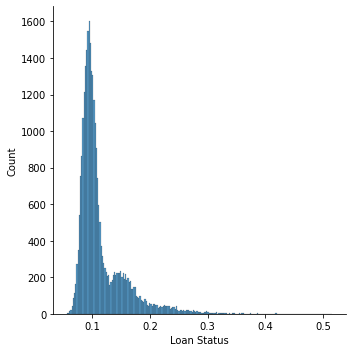

In [ ]:
sns.displot(sub_df['Loan Status'])

In [ ]:
# these classes allow you to request the Google drive API
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file = drive.CreateFile(metadata={"title": "MH_loan_default_prediction_1212_v03.csv"})
file.SetContentFile('MH_loan_default_prediction_1212_v03.csv')
file.Upload()